In [45]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv


In [46]:
!pip install livelossplot

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
import torchvision.transforms as transforms

import random 

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    set_device = 'cuda'
else:
    print("No GPU available!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
No GPU available!


In [47]:
batch_size = 100
set_seed(0)

class CSVDataset(Dataset):
    def __init__(self, path):
        dataset = pd.read_csv(path)
        if len(dataset.columns) != (28*28+1):
            dataset = pd.concat([pd.DataFrame({'Label': np.zeros(len(dataset.index))}), dataset], axis=1)
        assert len(dataset.columns)==28*28+1
        self.data = torch.tensor(dataset.iloc[:,1:].applymap(lambda x: x/255).values, 
                                 dtype=torch.float32).reshape(-1,1,28,28)
        self.targets = torch.tensor(dataset.iloc[:,0].values).type(torch.LongTensor)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

    def __len__(self):
        return len(self.targets)

train_dataset = CSVDataset('train.csv')
pred_dataset = CSVDataset('test.csv')

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.3).split(train_dataset.data, train_dataset.targets) 
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

train_loader = DataLoader(Subset(train_dataset,indices[0][:int(len(indices[0])*0.7)]), batch_size=batch_size, num_workers=1, shuffle=True)
valid_loader = DataLoader(Subset(train_dataset,indices[0][int(len(indices[0])*0.7):]), batch_size=batch_size*2, num_workers=1, shuffle=True)
test_loader = DataLoader(Subset(train_dataset,indices[1]), batch_size=batch_size*2, num_workers=1, shuffle=False)
pred_loader = DataLoader(pred_dataset, batch_size=batch_size*2, num_workers=1, shuffle=False)

In [48]:
class DeepCNN(nn.Module):
    def __init__(self, in_chnl=1, hid_chnl1=16, hid_chnl2=32, hid_dims1=256, hid_dims2=128, out_dims=10):
        super(DeepCNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_chnl, hid_chnl1, 5, stride=2))  # Dims in 28x28 -> out 12x12
        self.layer2 = nn.Sequential(nn.Conv2d(hid_chnl1, hid_chnl2, 5, stride=2))  # Dims in 12x12 -> out 4x4

        self.layer3 = nn.Sequential(nn.Linear(hid_chnl2*4*4, hid_dims1))
        self.layer4 = nn.Sequential(nn.Linear(hid_dims1, hid_dims2))
        self.layer5 = nn.Sequential(nn.Linear(hid_dims2, out_dims))

        self.activation = nn.GELU()
        self.fin_activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))

        x = x.flatten(start_dim=1)
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))

        x = self.fin_activation(self.layer5(x))

        return x

In [64]:
nb_epoch = 20
lrnrate = 1e-3

def train(model, dataloader, device=set_device):
    optimizer = torch.optim.Adam(model.parameters(), lr=lrnrate)
    criterion = nn.CrossEntropyLoss()
    model.train()

    train_loss, train_accuracy = 1,0

    for batch,target in dataloader:

        batch, target = batch.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output,target) 
        loss.backward() 
        nn.utils.clip_grad_norm_(model.parameters(),10)
        optimizer.step()

        pred = output.softmax(dim=1).max(dim=1)[1]

        train_loss += loss.detach()*batch.size(0)
        train_accuracy += accuracy_score(target.cpu().numpy(), pred.detach().cpu().numpy())*batch.size(0) 

    return model, train_loss/len(dataloader.dataset), train_accuracy/len(dataloader.dataset)


def valid(model, dataloader, device=set_device):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    val_loss, val_accuracy = 0,0

    with torch.no_grad():
        for batch,target in dataloader:

            batch, target = batch.to(device), target.to(device)

            output = model(batch)
            loss = criterion(output,target)
            pred = output.softmax(dim=1).max(dim=1)[1]

            val_loss += loss*batch.size(0)
            val_accuracy += accuracy_score(target.cpu().numpy(), pred.detach().cpu().numpy())*batch.size(0)

    return val_loss/len(dataloader.dataset), val_accuracy/len(dataloader.dataset)

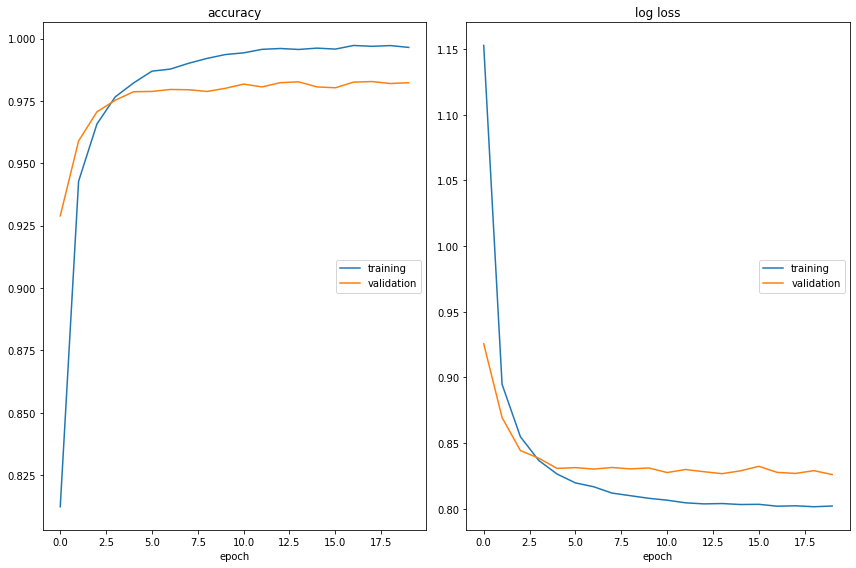

accuracy
	training         	 (min:    0.812, max:    0.997, cur:    0.996)
	validation       	 (min:    0.929, max:    0.983, cur:    0.982)
log loss
	training         	 (min:    0.802, max:    1.153, cur:    0.802)
	validation       	 (min:    0.826, max:    0.926, cur:    0.826)


In [50]:
dcnn = DeepCNN().to(set_device)

liveloss = PlotLosses()

for epoch in range(nb_epoch):
    logs = {}
    dcnn,train_loss,train_accuracy = train(dcnn, train_loader)
    valid_loss,valid_accuracy = valid(dcnn, valid_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    
    logs['val_' + 'log loss'] = valid_loss.item()
    logs['val_' + 'accuracy'] = valid_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()

In [51]:
print(f'Accuracy: {valid(dcnn, test_loader)[1]}')

Accuracy: 0.9815079365079366


In [62]:
predictions = pd.DataFrame({'ImageId': np.arange(1,28001,1), 
                            'Label': dcnn(pred_dataset.data).softmax(dim=1).max(dim=1)[1].detach().cpu().numpy()})

with open('predictions.csv','w') as file:
    file.write(predictions.to_csv(index=False))
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
!python ../score.py

Accuracy Score: 0.980714
Indicative Percentile Rank: 45.314531
